In [2]:
import pandas as pd
from PIL import Image
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch import nn
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
import os
from einops import rearrange, repeat
import einops
from glob import glob
from math import log
import math
from tqdm import tqdm
import pickle
#from staf import StafLayer
#from staf import INR
from mamba_ssm import Mamba
from mamba_ssm.modules.block import Block
import matplotlib.pyplot as plt
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
num_gpus = torch.cuda.device_count()
print(f"Number of GPUs: {num_gpus}")

for i in range(num_gpus):
    print(f"Device {i}: {torch.cuda.get_device_name(i)}")

Number of GPUs: 1
Device 0: NVIDIA H100 80GB HBM3


In [ ]:
###--Load image with PIL and display--###
image_path = "./Mamba/headshot.jpg"
image = Image.open(image_path).convert("RGB")
W, H = image.size


#downsampling if necessary
H = int(H//1.5)
W = int(W//1.5)

image = image.resize((W, H))

# Print the dimensions
print(f"The image resolution is: {W}x{H}")
image.show()

[0.8158799014302459, 0.4669265882737601, 0.39318315335301196, 0.3496289634580678, 0.3214582122211009, 0.29922900728976676, 0.2811309589124692, 0.28945880968655857, 0.2522539787375724, 0.2567642921609665, 0.29425056185771914, 0.2373431965764334, 0.2251777076629052, 0.2159592927828717, 0.26962090732414584, 0.20545312416340625, 0.1991296353529511, 0.36549758150585804, 0.7544619494727426, 0.46863113377076476]
[0.5432249290548312, 0.44678089421266204, 0.3921253087983769, 0.38128382907171915, 0.3438558805805103, 0.3106275013867457, 0.30078651708592274, 0.28606688098353183, 0.3061815124883014, 0.2689392561460756, 0.2850110275065823, 0.2738026173156538, 0.2634118779259882, 0.2750718870265469, 0.26389496996524225, 0.24593205413051472, 0.2558118267471244, 1.7959284061079572, 0.5388352206558179, 0.44635034195936407]


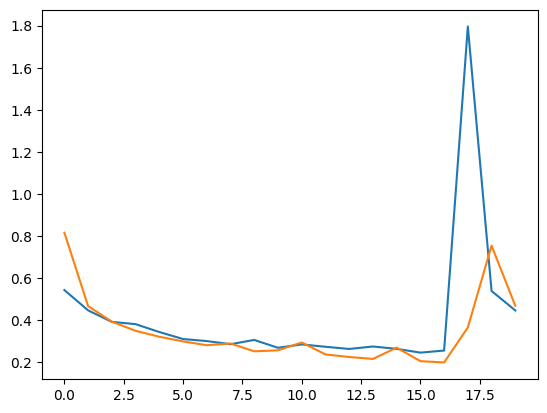

In [20]:
with open('./Mamba/cls_losses.pkl', 'rb') as file:
        losses = pickle.load(file)
with open('./Mamba/cls_val_losses.pkl', 'rb') as file:
        val_losses = pickle.load(file)
    
#print(losses[-15:])
print((losses))
print(val_losses)
plt.plot(val_losses)
plt.plot(losses)
plt.show()

In [6]:
###---Basic INR MLP Architecture, using ReLU---###
class ImageINRModel(torch.nn.Module):

    def __init__(self, input_size, hidden_size = 256, output_size = 3, num_hidden = 4):
        super(ImageINRModel, self).__init__()

        self.input = torch.nn.Linear(input_size, hidden_size)
        self.hidden = nn.ModuleList()
        
        layers = []
        for _ in range(num_hidden):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.ReLU())
        self.hidden = nn.Sequential(*layers)
        self.output = torch.nn.Linear(hidden_size, output_size)
        self.sig = torch.nn.Sigmoid()

    def forward(self, x):
        x = self.input(x)
        x = self.hidden(x)
        x = self.output(x)
        x = self.sig(x)

        return x

In [7]:
def fourier_encode(xy: torch.Tensor, freq: torch.Tensor) -> torch.Tensor:

    # Expand: (N, 2) → (N, 1, 2)
    xy = xy.unsqueeze(1)  # shape: (N, 1, 2)

    # (F,) → (1, F, 1), for broadcasting

    freq1 = freq[0:len(freq)//2 ]
    freq2 = freq[len(freq)//2:]

    
    freq1 = torch.tensor(freq1, dtype = torch.float32).view(1, -1, 1)
    freq2 = torch.tensor(freq2, dtype = torch.float32).view(1, -1, 1)

    # Multiply and encode
    scaled1 = 2 * torch.pi * (1/freq1) * xy  # shape: (N, F, 2)
    scaled2 = 2 * torch.pi * (1/freq2) * xy  # shape: (N, F, 2)

    sin_feat = torch.sin(scaled1)  # (N, F, 2)
    cos_feat = torch.cos(scaled2)  # (N, F, 2)

    # Concatenate and flatten last two dimensions: (N, F, 4) → (N, 4 * F)
    features = torch.cat([sin_feat, cos_feat], dim=-1)  # (N, F, 4)
    return features.view(xy.shape[0], -1)  # (N, 4 * F)

In [8]:
class BiMamba(torch.nn.Module):
    def __init__(self, dim = 512):
        super(BiMamba, self).__init__()
        
        self.f_mamba = Mamba(d_model = dim)
        self.r_mamba = Mamba(d_model = dim)
        
    def forward(self, x, **kwargs):
        x_f = self.f_mamba(x, **kwargs)
        x_r = torch.flip(self.r_mamba(torch.flip(x, dims=[1]), **kwargs), dims=[1])
        out = (x_f + x_r)/2
        
        return out
    
class MambaINRModel(torch.nn.Module):

    def __init__(self, input_size, token_dim = 512, output_size = 3, model_type = 'stacked'):
        super(MambaINRModel, self).__init__()
        if model_type == 'stacked':
            self.mamba = MambaStack(num = 6, token_dim = token_dim)
        else:
            self.mamba = BiMamba(token_dim = token_dim)
            
        self.input = torch.nn.Linear(input_size, token_dim)
        self.output = torch.nn.Linear(token_dim, output_size)
        self.sig = torch.nn.Sigmoid()
        
    def forward(self, x):
        x = self.input(x)
        x = self.mamba(x)
        x = self.output(x)
        x = self.sig(x)

        return x

class MambaStack(torch.nn.Module):
    def __init__(self, num = 3, token_dim = 512):
        super(MambaStack, self).__init__()
        self.blocks = nn.ModuleList([
            Block(
                dim=token_dim,
                mixer_cls= lambda dim: BiMamba(dim),
                mlp_cls= lambda dim: torch.nn.Sequential(
                    nn.Linear(dim, 4 * dim),
                    nn.GELU(),
                    nn.Linear(4 * dim, dim),
                ),
                norm_cls=nn.LayerNorm,  # or RMSNorm
                fused_add_norm=False
            )
            for _ in range(num)
        ])
    
    def forward(self, x):
        residual = None
        for block in self.blocks:
            x, residual = block(x, residual=residual)
        return x


torch.Size([3410, 3410, 3])
The image resolution is: 341x341


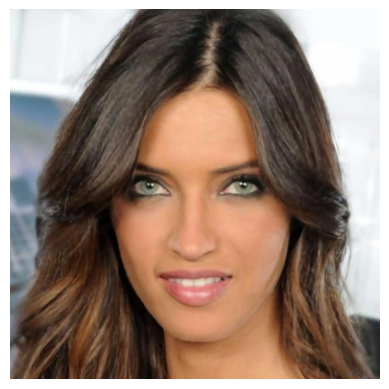

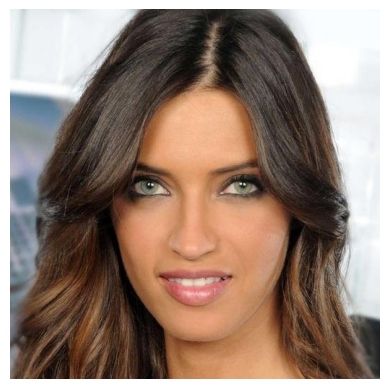

"\n\nplt.imshow(dif)\nplt.axis('off')\nplt.savefig(f'Mamba_ordered_dif.png')\nplt.show()"

In [19]:
#Evaluation cell, uncomment the correct model and corresponding lines, make sure the paremeters match and the correct frequency file is loaded if using gaussian


# Use this for standard
#model = ImageINRModel(input_size = 2)

# Use this for fourier
#model = ImageINRModel(input_size = 4) 

# use this for gaussian or passing in custom frequencies, change this to correct number of frequencies from training
num_freq = 128
model = ImageINRModel(input_size = 4*num_freq).to(device)

#num_freq = 128
#model = MambaINRModel(input_size = 4*num_freq).to(device)

#model = INR(2, 256, 4, 3) #Use this as model if evaluating STAF model

#define path to model checkpoint 
path = './Mamba/headshot_gaussian_10.pth' 
checkpoint = torch.load(path)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

# Create normalized grid: x in [0, 1], y in [0, 1]
x = np.linspace(0, 1, int(W*10))
y = np.linspace(0, 1, int(H*10))
xx, yy = np.meshgrid(x, y)  # shape: (H, W)

X = torch.tensor(np.stack([xx, yy], axis=-1).reshape(-1, 2), dtype = torch.float32)  # shape: (H*W, 2)

# Use this for gaussian to load corresponding frequencies, otherwise comment out
with open('./Mamba/freq_10.pkl', 'rb') as file:
    freq = pickle.load(file)

X = fourier_encode(X, freq = freq) # comment this line out if using standard or STAF, use freq = [1, 1] for fourier or freq = freq for gaussian
'''with open('./Mamba/random_scan_full_scan.pkl', 'rb') as file:
    perm = pickle.load(file)

X = X[perm]'''

with torch.no_grad():
    Y = model(X.unsqueeze(0).to(device))

Y = Y.detach().cpu()

'''inverse_perm = torch.empty_like(perm)
inverse_perm[perm] = torch.arange(len(perm))

# Step 3: Restore original order
Y = Y[0][inverse_perm]'''
image = Y.reshape(int(H*10), int(W*10), 3)
image = torch.clip(image, 0, 1)
print(image.shape)
    
gt = Image.open("./Mamba/headshot.jpg").convert("RGB")

#W, H = gt.size[0]//10, gt.size[1]//10 #if you downsampled the training image
#gt = gt.resize((W, H))

to_tensor = transforms.ToTensor()
gt = to_tensor(gt)
gt = rearrange(gt, 'k i j -> i j k')

'''dif = torch.sum(torch.abs(gt - image), axis = 2)/3

gt_loss = gt.reshape(H*W, 3)

loss_fn = torch.nn.MSELoss()
loss = loss_fn(gt.reshape(H*W, 3), Y.squeeze(0))

psnr = 10 * torch.log10(1.0 / loss)
print(f'PSNR is: {psnr.item()}')'''


print(f"The image resolution is: {W}x{H}")
plt.imshow(image)
plt.axis('off')
plt.savefig(f'Mamba_ordered_pred.png')
plt.show()

plt.imshow(gt)
plt.axis('off')
plt.savefig(f'ground_truth.png')
plt.show()
'''

plt.imshow(dif)
plt.axis('off')
plt.savefig(f'Mamba_ordered_dif.png')
plt.show()'''

In [231]:
from math import log10, sqrt
import cv2
import numpy as np

def PSNR(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if(mse == 0):  # MSE is zero means no noise is present in the signal .
                  # Therefore PSNR have no importance.
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr

def run():
    original = cv2.imread("./Mamba/image_gt.png")
    compressed = cv2.imread("./Mamba/image_pred.png")
    print(original.shape)
    print(original[240][320])
    
    value = PSNR(original, compressed)
    print(f"PSNR value is {value} dB")
     
run()

(480, 640, 3)
[ 63  75 112]
PSNR value is 39.06652718062247 dB


In [ ]:
#model = ImageINRModel()
model = INR(2, 256, 4, 3)
path = './checkpoint.pth'

checkpoint = torch.load("headshot_STAF.pth")
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

res_factors = [10]
for f in res_factors:
    H, W = 267*f, 232*f

    # Create normalized grid: x in [0, 1], y in [0, 1]
    x = np.linspace(0, 1, W)
    y = np.linspace(0, 1, H)
    xx, yy = np.meshgrid(x, y)  # shape: (H, W)

    coords = torch.tensor(np.stack([xx, yy], axis=-1).reshape(-1, 2), dtype = torch.float32)  # shape: (H*W, 2)
    '''with open('./freq_10.pkl', 'rb') as file:
        freq = pickle.load(file)

    coords = fourier_encode(coords, freq = freq)'''
    X = torch.tensor(coords, dtype=torch.float32)  # (H*W, 2)

    with torch.no_grad():
        Y = model(X)  # shape: (H*W, 3)

    image = Y.reshape(H, W, 3).cpu().numpy()
    image2 = (image * 255).astype(np.uint8)
    image2 = Image.fromarray(image2)
    image2.save('headshot_STAF.png')

    print(H)

    # Clip values to [0, 1] if needed
    #image = np.clip(image, 0, 1)
    import matplotlib.pyplot as plt

    plt.imshow(image)
    plt.axis('off')
    plt.show()
    
image = Image.open("./headshot.jpg").convert("RGB")

width, height = image.size

image2 = image.resize((width//10, height//10))

# Print the dimensions
print(f"The image resolution is: {width}x{height}")
plt.imshow(image2)
plt.axis('off')
plt.show()

/tmp/ipykernel_133/2952224900.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(coords, dtype=torch.float32)  # (H*W, 2)


In [3]:
class Celeba(Dataset):

    def __init__(self, root_path, split, resize = 128):
        self.data = glob(os.path.join(root_path, "*.jpg"))
        if split == 'train':
            self.data = self.data[:160000]
        elif split == 'val':
            self.data = self.data[160001:180000]
        elif split == 'test':
            self.data = self.data[180001:200000]
        elif split == 'trial':
            self.data = self.data[:512]
        self.transform = transforms.Compose([
            transforms.Resize(resize),
            transforms.CenterCrop(resize),
            transforms.ToTensor(),
        ])
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = Image.open(self.data[idx])
        x = self.transform(img)
        return {'inp': x, 'gt': x}

class ImgTokenizer(nn.Module):

    def __init__(self, input_size, patch_size, dim, padding=0, img_channels=3):
        super().__init__()
        if isinstance(input_size, int):
            input_size = (input_size, input_size)
        if isinstance(patch_size, int):
            patch_size = (patch_size, patch_size)
        if isinstance(padding, int):
            padding = (padding, padding)
        self.patch_size = patch_size
        self.padding = padding
        self.prefc = nn.Linear(patch_size[0] * patch_size[1] * img_channels, dim)
        n_patches = ((input_size[0] + padding[0] * 2) // patch_size[0]) * ((input_size[1] + padding[1] * 2)  // patch_size[1])
        self.posemb = nn.Parameter(torch.randn(n_patches, dim))

    def forward(self, data):
        x = data['inp']
        p = self.patch_size
        x = F.unfold(x, p, stride=p, padding=self.padding) # (B, C * p * p, L)
        x = x.permute(0, 2, 1).contiguous()
        x =  self.prefc(x) + self.posemb.unsqueeze(0)
        return x

# ===============================================================
# --- 1. Simplified TransINR Architeture ---
# ===============================================================

# helpers
def exists(val):
    return val is not None

def default(val, d):
    return val if exists(val) else d

def cache_fn(f):
    cache = None
    @wraps(f)
    def cached_fn(*args, _cache = True, **kwargs):
        if not _cache:
            return f(*args, **kwargs)
        nonlocal cache
        if cache is not None:
            return cache
        cache = f(*args, **kwargs)
        return cache
    return cached_fn

# helper classes
class PreNorm(nn.Module):
    def __init__(self, dim, fn, context_dim = None):
        super().__init__()
        self.fn = fn
        self.norm = nn.LayerNorm(dim)
        self.norm_context = nn.LayerNorm(context_dim) if exists(context_dim) else None

    def forward(self, x, **kwargs):
        x = self.norm(x)
        if exists(self.norm_context):
            context = kwargs['context']
            normed_context = self.norm_context(context)
            kwargs.update(context = normed_context)
        return self.fn(x, **kwargs)

class GEGLU(nn.Module):
    def forward(self, x):
        x, gates = x.chunk(2, dim = -1)
        return x * F.gelu(gates)

class FeedForward(nn.Module):
    def __init__(self, dim, mult = 4):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, dim * mult * 2),
            GEGLU(),
            nn.Linear(dim * mult, dim)
        )
    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, query_dim, context_dim = None, heads = 8, dim_head = 64):
        super().__init__()
        inner_dim = dim_head * heads
        context_dim = default(context_dim, query_dim)
        self.scale = dim_head ** -0.5
        self.heads = heads
        self.to_q = nn.Linear(query_dim, inner_dim, bias = False)
        self.to_kv = nn.Linear(context_dim, inner_dim * 2, bias = False)
        self.to_out = nn.Linear(inner_dim, query_dim)

    def forward(self, x, context = None, mask = None):
        h = self.heads
        q = self.to_q(x)
        context = default(context, x)
        k, v = self.to_kv(context).chunk(2, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> (b h) n d', h = h), (q, k, v))
        sim = torch.einsum('b i d, b j d -> b i j', q, k) * self.scale
        if exists(mask):
            mask = rearrange(mask, 'b ... -> b (...)')
            max_neg_value = -torch.finfo(sim.dtype).max
            mask = repeat(mask, 'b j -> (b h) () j', h = h)
            sim.masked_fill_(~mask, max_neg_value)
        attn = sim.softmax(dim = -1)
        out = torch.einsum('b i j, b j d -> b i d', attn, v)
        out = rearrange(out, '(b h) n d -> b n (h d)', h = h)
        return self.to_out(out)


class TransformerEncoder(nn.Module):
    def __init__(self, dim, depth, n_head):
        super().__init__()
        self.layers = nn.ModuleList()
        for _ in range(depth):
            self.layers.append(
               nn.ModuleList([PreNorm(dim, Attention(dim, heads = n_head)),
                PreNorm(dim, FeedForward(dim))]
            ))
            
    def forward(self, x):
        for norm_attn, norm_ff in self.layers:
            x = x + norm_attn(x)
            x = x + norm_ff(x)
        return x
        
        
"""
    Generates sinusoidal positional embeddings.
    
    Args:
        n (int): The number of positions (num_latents).
        d (int): The embedding dimension (latent_dim).
    
    Returns:
        torch.Tensor: A tensor of shape (n, d) with sinusoidal embeddings.
    """
    # Ensure latent_dim is even for sin/cos pairs       
# This helper function creates the sinusoidal embeddings
def get_sinusoidal_embeddings(n, d):
    assert d % 2 == 0, "latent_dim must be an even number for sinusoidal embeddings"
    
    position = torch.arange(n, dtype=torch.float).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d, 2).float() * -(log(10000.0) / d))
    
    pe = torch.zeros(n, d)
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    return pe
    
    

def batched_linear_mm(x, wb):
    # x: (B, N, D1); wb: (B, D1 + 1, D2) or (D1 + 1, D2)
    one = torch.ones(*x.shape[:-1], 1, device=x.device)
    return torch.matmul(torch.cat([x, one], dim=-1), wb)


class HypoMlp(nn.Module):

    def __init__(self, depth, in_dim, out_dim, hidden_dim, use_pe, pe_dim, out_bias=0, pe_sigma=1024):
        super().__init__()
        self.use_pe = use_pe
        self.pe_dim = pe_dim
        self.pe_sigma = pe_sigma
        self.depth = depth
        self.param_shapes = dict()
        if use_pe:
            last_dim = in_dim * pe_dim
        else:
            last_dim = in_dim
        for i in range(depth):
            cur_dim = hidden_dim if i < depth - 1 else out_dim
            self.param_shapes[f'wb{i}'] = (last_dim + 1, cur_dim)
            last_dim = cur_dim
        self.relu = nn.ReLU()
        self.params = None
        self.out_bias = out_bias

    def set_params(self, params):
        self.params = params

    def convert_posenc(self, x):
        w = torch.exp(torch.linspace(0, np.log(self.pe_sigma), self.pe_dim // 2, device=x.device))
        x = torch.matmul(x.unsqueeze(-1), w.unsqueeze(0)).view(*x.shape[:-1], -1)
        x = torch.cat([torch.cos(np.pi * x), torch.sin(np.pi * x)], dim=-1)
        return x

    def forward(self, x):
        B, query_shape = x.shape[0], x.shape[1: -1]
        x = x.view(B, -1, x.shape[-1])
        if self.use_pe:
            x = self.convert_posenc(x)
        for i in range(self.depth):
            x = batched_linear_mm(x, self.params[f'wb{i}'])
            if i < self.depth - 1:
                x = self.relu(x)
            else:
                x = x + self.out_bias
        x = x.view(B, *query_shape, -1)
        return x


# main class
def init_wb(shape):
    weight = torch.empty(shape[1], shape[0] - 1)
    nn.init.kaiming_uniform_(weight, a=math.sqrt(5))

    bias = torch.empty(shape[1], 1)
    fan_in, _ = nn.init._calculate_fan_in_and_fan_out(weight)
    bound = 1 / math.sqrt(fan_in) if fan_in > 0 else 0
    nn.init.uniform_(bias, -bound, bound)

    return torch.cat([weight, bias], dim=1).t().detach()


class TransInr(nn.Module):

    def __init__(self, n_groups):
        super().__init__()
        #dim = transformer_encoder['args']['dim']
        dim = 512
        self.tokenizer = ImgTokenizer(128, 8, 512)
        self.hyponet = HypoMlp(depth = 5, in_dim = 2, out_dim = 3, hidden_dim = 256, use_pe = True, pe_dim = 512, out_bias = 0.5)
        self.transformer_encoder = TransformerEncoder(dim = 512, depth = 6, n_head = 12)

        self.base_params = nn.ParameterDict()
        n_wtokens = 0
        self.wtoken_postfc = nn.ModuleDict()
        self.wtoken_rng = dict()
        for name, shape in self.hyponet.param_shapes.items():
            self.base_params[name] = nn.Parameter(init_wb(shape))
            g = min(n_groups, shape[1])
            assert shape[1] % g == 0
            self.wtoken_postfc[name] = nn.Sequential(
                nn.LayerNorm(dim),
                nn.Linear(dim, shape[0] - 1),
            )
            self.wtoken_rng[name] = (n_wtokens, n_wtokens + g)
            n_wtokens += g
        self.wtokens = nn.Parameter(torch.randn(n_wtokens, dim))

    def forward(self, data):
        dtokens = self.tokenizer(data)
        B = dtokens.shape[0]
        wtokens = einops.repeat(self.wtokens, 'n d -> b n d', b=B)
        trans_out = self.transformer_encoder(torch.cat([dtokens, wtokens], dim=1))
        trans_out = trans_out[:, -len(self.wtokens):, :]

        params = dict()
        for name, shape in self.hyponet.param_shapes.items():
            wb = einops.repeat(self.base_params[name], 'n m -> b n m', b=B)
            w, b = wb[:, :-1, :], wb[:, -1:, :]

            l, r = self.wtoken_rng[name]
            x = self.wtoken_postfc[name](trans_out[:, l: r, :])
            x = x.transpose(-1, -2) # (B, shape[0] - 1, g)
            w = F.normalize(w * x.repeat(1, 1, w.shape[2] // x.shape[2]), dim=1)

            wb = torch.cat([w, b], dim=1)
            params[name] = wb

        self.hyponet.set_params(params)
        return self.hyponet

In [7]:
class Celeba(Dataset):

    def __init__(self, root_path, split, resize = 178):
        self.data = glob(os.path.join(root_path, "*.jpg"))
        if split == 'train':
            self.data = self.data[:160000]
        elif split == 'val':
            self.data = self.data[160001:180000]
        elif split == 'test':
            self.data = self.data[180001:200000]
        elif split == 'trial':
            self.data = self.data[:512]
        self.transform = transforms.Compose([
            transforms.Resize(resize),
            transforms.CenterCrop(resize),
            transforms.ToTensor(),
        ])
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = Image.open(self.data[idx])
        x = self.transform(img)
        return {'inp': x, 'gt': x}

class ImgTokenizer(nn.Module):

    def __init__(self, input_size, patch_size, dim, padding=1, img_channels=3):
        super().__init__()
        if isinstance(input_size, int):
            input_size = (input_size, input_size)
        if isinstance(patch_size, int):
            patch_size = (patch_size, patch_size)
        if isinstance(padding, int):
            padding = (padding, padding)
        self.patch_size = patch_size
        self.padding = padding
        self.prefc = nn.Linear(patch_size[0] * patch_size[1] * img_channels, dim)
        n_patches = ((input_size[0] + padding[0] * 2) // patch_size[0]) * ((input_size[1] + padding[1] * 2)  // patch_size[1])
        self.posemb = nn.Parameter(torch.randn(n_patches, dim))

    def forward(self, data):
        x = data['inp']
        p = self.patch_size
        x = F.unfold(x, p, stride=p, padding=self.padding) # (B, C * p * p, L)
        x = x.permute(0, 2, 1).contiguous()
        x =  self.prefc(x) + self.posemb.unsqueeze(0)
        return x

# ===============================================================
# --- 1. Simplified TransINR Architeture ---
# ===============================================================

# helpers
def exists(val):
    return val is not None

def default(val, d):
    return val if exists(val) else d

def cache_fn(f):
    cache = None
    @wraps(f)
    def cached_fn(*args, _cache = True, **kwargs):
        if not _cache:
            return f(*args, **kwargs)
        nonlocal cache
        if cache is not None:
            return cache
        cache = f(*args, **kwargs)
        return cache
    return cached_fn

# helper classes
class PreNorm(nn.Module):
    def __init__(self, dim, fn, context_dim = None):
        super().__init__()
        self.fn = fn
        self.norm = nn.LayerNorm(dim)
        self.norm_context = nn.LayerNorm(context_dim) if exists(context_dim) else None

    def forward(self, x, **kwargs):
        x = self.norm(x)
        if exists(self.norm_context):
            context = kwargs['context']
            normed_context = self.norm_context(context)
            kwargs.update(context = normed_context)
        return self.fn(x, **kwargs)

class GEGLU(nn.Module):
    def forward(self, x):
        x, gates = x.chunk(2, dim = -1)
        return x * F.gelu(gates)

class FeedForward(nn.Module):
    def __init__(self, dim, mult = 4):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, dim * mult * 2),
            GEGLU(),
            nn.Linear(dim * mult, dim)
        )
    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, query_dim, context_dim = None, heads = 8, dim_head = 64):
        super().__init__()
        inner_dim = dim_head * heads
        context_dim = default(context_dim, query_dim)
        self.scale = dim_head ** -0.5
        self.heads = heads
        self.to_q = nn.Linear(query_dim, inner_dim, bias = False)
        self.to_kv = nn.Linear(context_dim, inner_dim * 2, bias = False)
        self.to_out = nn.Linear(inner_dim, query_dim)

    def forward(self, x, context = None, mask = None):
        h = self.heads
        q = self.to_q(x)
        context = default(context, x)
        k, v = self.to_kv(context).chunk(2, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> (b h) n d', h = h), (q, k, v))
        sim = torch.einsum('b i d, b j d -> b i j', q, k) * self.scale
        if exists(mask):
            mask = rearrange(mask, 'b ... -> b (...)')
            max_neg_value = -torch.finfo(sim.dtype).max
            mask = repeat(mask, 'b j -> (b h) () j', h = h)
            sim.masked_fill_(~mask, max_neg_value)
        attn = sim.softmax(dim = -1)
        out = torch.einsum('b i j, b j d -> b i d', attn, v)
        out = rearrange(out, '(b h) n d -> b n (h d)', h = h)
        return self.to_out(out)


class TransformerEncoder(nn.Module):
    def __init__(self, dim, depth, n_head):
        super().__init__()
        self.layers = nn.ModuleList()
        for _ in range(depth):
            self.layers.append(
               nn.ModuleList([PreNorm(dim, Attention(dim, heads = n_head)),
                PreNorm(dim, FeedForward(dim))]
            ))
            
    def forward(self, x):
        for norm_attn, norm_ff in self.layers:
            x = x + norm_attn(x)
            x = x + norm_ff(x)
        return x
        
        
"""
    Generates sinusoidal positional embeddings.
    
    Args:
        n (int): The number of positions (num_latents).
        d (int): The embedding dimension (latent_dim).
    
    Returns:
        torch.Tensor: A tensor of shape (n, d) with sinusoidal embeddings.
    """
    # Ensure latent_dim is even for sin/cos pairs       
# This helper function creates the sinusoidal embeddings
def get_sinusoidal_embeddings(n, d):
    assert d % 2 == 0, "latent_dim must be an even number for sinusoidal embeddings"
    
    position = torch.arange(n, dtype=torch.float).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d, 2).float() * -(log(10000.0) / d))
    
    pe = torch.zeros(n, d)
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    return pe
    
    

def batched_linear_mm(x, wb):
    # x: (B, N, D1); wb: (B, D1 + 1, D2) or (D1 + 1, D2)
    one = torch.ones(*x.shape[:-1], 1, device=x.device)
    return torch.matmul(torch.cat([x, one], dim=-1), wb)


class HypoMlp(nn.Module):

    def __init__(self, depth, in_dim, out_dim, hidden_dim, use_pe, pe_dim, out_bias=0, pe_sigma=1024):
        super().__init__()
        self.use_pe = use_pe
        self.pe_dim = pe_dim
        self.pe_sigma = pe_sigma
        self.depth = depth
        self.param_shapes = dict()
        if use_pe:
            last_dim = in_dim * pe_dim
        else:
            last_dim = in_dim
        for i in range(depth):
            cur_dim = hidden_dim if i < depth - 1 else out_dim
            self.param_shapes[f'wb{i}'] = (last_dim + 1, cur_dim)
            last_dim = cur_dim
        self.relu = nn.ReLU()
        self.params = None
        self.out_bias = out_bias

    def set_params(self, params):
        self.params = params

    def convert_posenc(self, x):
        w = torch.exp(torch.linspace(0, np.log(self.pe_sigma), self.pe_dim // 2, device=x.device))
        x = torch.matmul(x.unsqueeze(-1), w.unsqueeze(0)).view(*x.shape[:-1], -1)
        x = torch.cat([torch.cos(np.pi * x), torch.sin(np.pi * x)], dim=-1)
        return x

    def forward(self, x):
        B, query_shape = x.shape[0], x.shape[1: -1]
        x = x.view(B, -1, x.shape[-1])
        if self.use_pe:
            x = self.convert_posenc(x)
        for i in range(self.depth):
            x = batched_linear_mm(x, self.params[f'wb{i}'])
            if i < self.depth - 1:
                x = self.relu(x)
            else:
                x = x + self.out_bias
        x = x.view(B, *query_shape, -1)
        return x


# main class
def init_wb(shape):
    weight = torch.empty(shape[1], shape[0] - 1)
    nn.init.kaiming_uniform_(weight, a=math.sqrt(5))

    bias = torch.empty(shape[1], 1)
    fan_in, _ = nn.init._calculate_fan_in_and_fan_out(weight)
    bound = 1 / math.sqrt(fan_in) if fan_in > 0 else 0
    nn.init.uniform_(bias, -bound, bound)

    return torch.cat([weight, bias], dim=1).t().detach()


class TransInr(nn.Module):

    def __init__(self, n_groups):
        super().__init__()
        #dim = transformer_encoder['args']['dim']
        dim = 512
        self.tokenizer = ImgTokenizer(178, 9, 512)
        self.hyponet = HypoMlp(depth = 5, in_dim = 2, out_dim = 3, hidden_dim = 256, use_pe = True, pe_dim = 512, out_bias = 0.5)
        self.transformer_encoder = TransformerEncoder(dim = 512, depth = 6, n_head = 12)

        self.base_params = nn.ParameterDict()
        n_wtokens = 0
        self.wtoken_postfc = nn.ModuleDict()
        self.wtoken_rng = dict()
        for name, shape in self.hyponet.param_shapes.items():
            self.base_params[name] = nn.Parameter(init_wb(shape))
            g = min(n_groups, shape[1])
            assert shape[1] % g == 0
            self.wtoken_postfc[name] = nn.Sequential(
                nn.LayerNorm(dim),
                nn.Linear(dim, shape[0] - 1),
            )
            self.wtoken_rng[name] = (n_wtokens, n_wtokens + g)
            n_wtokens += g
        self.wtokens = nn.Parameter(torch.randn(n_wtokens, dim))

    def forward(self, data):
        dtokens = self.tokenizer(data)
        B = dtokens.shape[0]
        wtokens = einops.repeat(self.wtokens, 'n d -> b n d', b=B)
        trans_out = self.transformer_encoder(torch.cat([dtokens, wtokens], dim=1))
        trans_out = trans_out[:, -len(self.wtokens):, :]

        params = dict()
        for name, shape in self.hyponet.param_shapes.items():
            wb = einops.repeat(self.base_params[name], 'n m -> b n m', b=B)
            w, b = wb[:, :-1, :], wb[:, -1:, :]

            l, r = self.wtoken_rng[name]
            x = self.wtoken_postfc[name](trans_out[:, l: r, :])
            x = x.transpose(-1, -2) # (B, shape[0] - 1, g)
            w = F.normalize(w * x.repeat(1, 1, w.shape[2] // x.shape[2]), dim=1)

            wb = torch.cat([w, b], dim=1)
            params[name] = wb

        self.hyponet.set_params(params)
        return self.hyponet

torch.Size([3, 3, 178, 178])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.037146688..1.1243048].


28.1482938923215
torch.Size([3, 31684, 3])


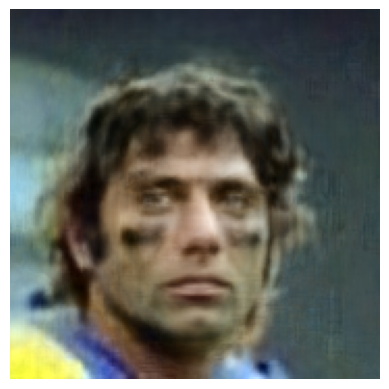

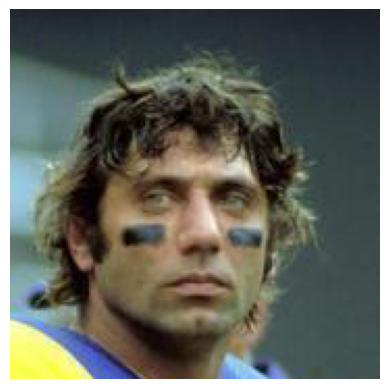

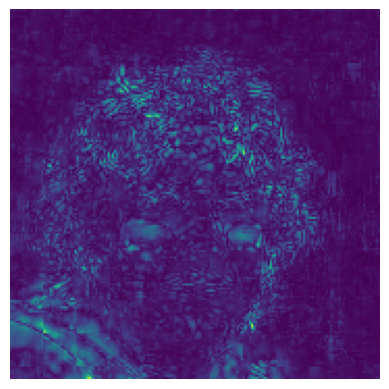

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.025515735..0.9812587].


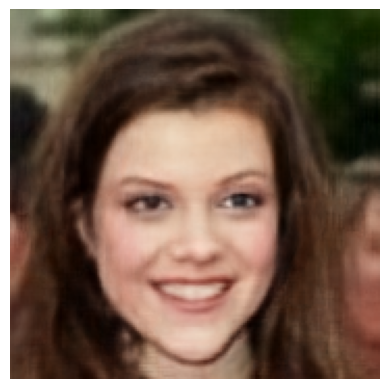

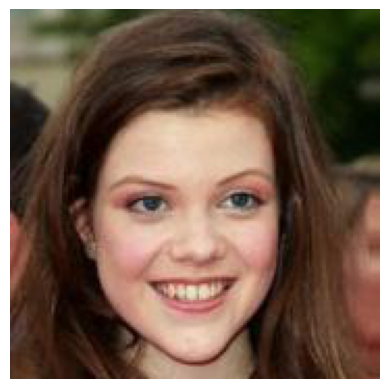

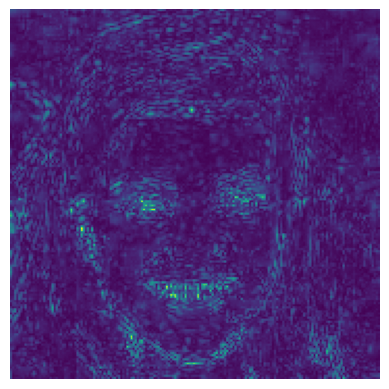

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.018751055..1.0225074].


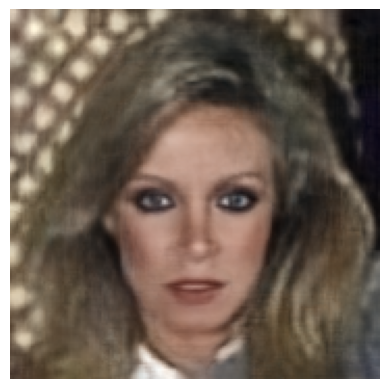

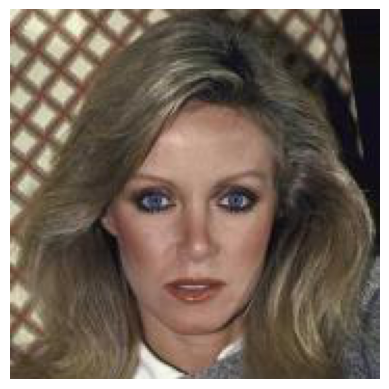

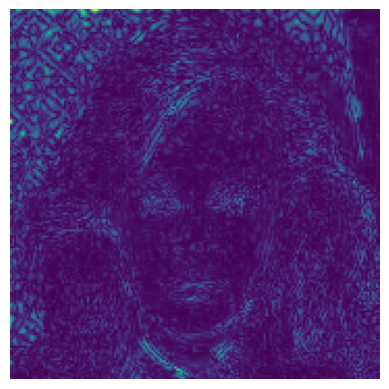

'to_pil_image = transforms.ToPILImage()\npil_image = to_pil_image(pred)'

In [9]:
model = TransInr(64).to(device)

#img_path = '/home/idies/.cache/kagglehub/datasets/therealcyberlord/50k-celeba-dataset-64x64/versions/1/50k'
img_path = '/home/idies/.cache/kagglehub/datasets/jessicali9530/celeba-dataset/versions/2/img_align_celeba/img_align_celeba'
path = './TransINR_Test/TransINR_CelebA_35.pth'

checkpoint = torch.load(path)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

dataset = Celeba(img_path, 'test', resize=178)
data = np.concatenate([dataset[i]['inp'].unsqueeze(0) for i in range(3)], axis=0)
data = torch.tensor(data)

B = 1
print(data.shape)



def get_coord_grid(h, w, device):
    y, x = torch.meshgrid(
        torch.linspace(-1, 1, steps=h, device=device),
        torch.linspace(-1, 1, steps=w, device=device),
        indexing='ij'
    )
    coords = torch.stack([x, y], dim=-1)  # (H, W, 2)
    return coords.view(-1, 2)  # (H*W, 2)

inp = data.to(device)
#inp = data.unsqueeze(0).to(device)  # (B, 3, H, W)
B, C, H, W = inp.shape
coords = get_coord_grid(H, W, device).unsqueeze(0).repeat(B, 1, 1)  # (B, H*W, 2)
gt = inp.permute(0, 2, 3, 1).reshape(B, -1, 3)  # (B, H*W, 3)

hypo_net = model({'inp': inp})  # returns configured HypoMlp
pred = hypo_net(coords)  # (B, H*W, 3)

loss_fn = torch.nn.MSELoss()
loss = loss_fn(pred.squeeze(0), gt.squeeze(0))
loss_desired = 0.0015

psnr = 10*math.log10(1/loss)
print(psnr)

print(pred.shape)

pred = pred.view(B, H, W, C)
data = rearrange(data, 'a k i j -> a i j k')



for i in range(B):
    pred_curr = pred[i].detach().cpu().numpy()
    data_curr = data[i].detach().cpu().numpy()

    plt.imshow(pred_curr)
    plt.axis('off')
    plt.savefig(f'image_{i}_pred.png')
    plt.show()
    
    plt.imshow(data_curr)
    plt.axis('off')
    plt.savefig(f'image_{i}_data.png')

    plt.show()

    dif = np.sum(np.abs(pred_curr - data_curr), axis = 2)/3.0
    plt.imshow(dif)
    plt.axis('off')
    plt.savefig(f'image_{i}_dif.png')
    plt.show()
    
#pred = rearrange(pred, 'i j k -> k i j')
#print(pred.shape)


'''to_pil_image = transforms.ToPILImage()
pil_image = to_pil_image(pred)'''
#image = to_pil_image(data)
#pil_image.save("output_image.png")
#pil_image.show()
    

In [11]:
model = TransInr(n_groups=64).to(device)
img_path = '/home/idies/.cache/kagglehub/datasets/jessicali9530/celeba-dataset/versions/2/img_align_celeba/img_align_celeba'
path = './TransINR_Test/TransINR_CelebA_35.pth'

checkpoint = torch.load(path)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

# --- Data Preparation ---
val_dataset = Celeba(img_path, 'val', resize=178)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True, num_workers=8, pin_memory=True)

# --- Model ---

loss_fn = torch.nn.MSELoss()

# --- Utility: Create Coordinate Grid ---
def get_coord_grid(h, w, device):
    y, x = torch.meshgrid(
        torch.linspace(-1, 1, steps=h, device=device),
        torch.linspace(-1, 1, steps=w, device=device),
        indexing='ij'
    )
    coords = torch.stack([x, y], dim=-1)  # (H, W, 2)
    return coords.view(-1, 2)  # (H*W, 2)

# --- Validation Loop ---
model.eval()
total_val_loss = 0.0
with torch.no_grad():
    for batch in tqdm(val_loader):
        inp = batch['inp'].to(device)
        B, C, H, W = inp.shape

        coords = get_coord_grid(H, W, device).repeat(B, 1, 1)  # (4096, 2)
        gt = inp.permute(0, 2, 3, 1).reshape(B, -1, 3)

        hypo_net = model({'inp': inp})
        pred = hypo_net(coords)

        loss = loss_fn(pred, gt)
        total_val_loss += loss.item()

val_loss = total_val_loss / len(val_loader)
print(f"[Epoch] Val Loss: {val_loss:.6f}")


100%|██████████| 1250/1250 [00:56<00:00, 22.03it/s]

[Epoch] Val Loss: 0.001820


In [12]:
psnr = 10*math.log10(1/val_loss)
print(psnr)

27.400352787649357
